In [526]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import fits
from matplotlib.colors import LogNorm

In [527]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def load_plz(pattern):
    
    files = sorted(glob.glob(pattern))
    files = map(fits.open, files)
    files = [file[0].data for file in files]
    return np.array(files)
    
def lazy_load_plz(pattern):
    
    files = sorted(glob.glob(pattern))
    files = map(fits.open, files)
    return files

def num_sd(arr):
    
    return np.abs(arr - arr.mean()) / arr.std()
    
def apply_mask(arr, mask):
    
    arr = arr.astype(np.float32)
    
    arr *= mask
    arr[1:-1, 1:-1] += ~mask[1:-1, 1:-1] * 0.25 * \
                      (arr[:-2, 1:-1] + arr[2:, 1:-1] +
                       arr[1:-1, :-2] + arr[1:-1, 2:])
    return arr

In [528]:
reduced_star = load_plz("data/*star_re*")[0]

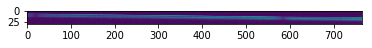

In [529]:
cropped= reduced_star[15:45,:]
plt.imshow(cropped)

In [530]:
temp = 11361
temp_err = 66 
h = 6.626e-34
c = 3*10**8
k = 1.381e-23
def blackbody(Lambda, T):
    return 2*h*c**2/Lambda**5/(np.exp(h*c/(Lambda*k*T))-1)    

In [531]:
attempt0 = np.mean(cropped,axis=0)

for i in range(len(attempt0)):
    if attempt0[i] == np.min(attempt0):
        H_abs_loc = i
    if attempt0[i] == np.min(attempt0[500:650]):
        H_abs2 = i
ang_per_pixel = (H_abs2 - H_abs_loc)/520
shift1 = (4341 - H_abs_loc*ang_per_pix)        #lower level calibrations 
shift2 = (4861 - H_abs2*ang_per_pix)           #to get an idea of the right answer
ang_per_pixel = (H_abs2 - H_abs_loc)/520
shift = (shift1 + shift2) / 2
x = np.linspace(shift,(shift+len(attempt0)), 765)

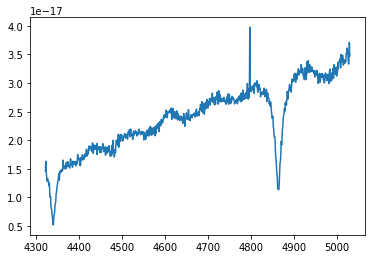

In [568]:
star_spec = attempt0/blackbody(x*1e-10,temp) #divide out some good blackbody stuff
plt.plot(x,star_spec)
#plt.plot(x, blackbody(x*1e-10,temp)/1e37)

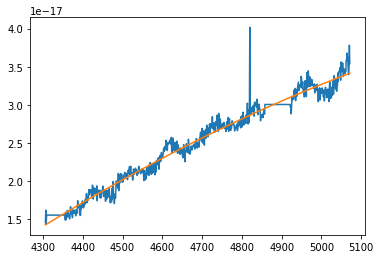

In [533]:
for i in range(len(star_spec)):
    if 2<i<50 :
        star_spec[i]=(star_spec[1]+star_spec[50])/2
    if 550<i<615:
        star_spec[i]=(star_spec[549]+star_spec[620])/2
N = 2
data_fitfunc = np.poly1d(np.polyfit(x,star_spec,N))
plt.plot(x,star_spec)
plt.plot(x,data_fitfunc(x))

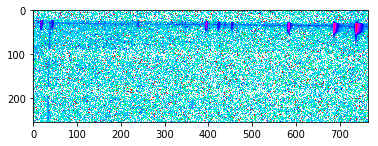

In [534]:
nebulae = sorted(glob.glob("data/nebula_reduced.fits"))
nebulae = list(map(fits.open, nebulae[:]))
nebulae = nebulae[0][0].data
plt.imshow(nebulae, cmap='hsv',norm=LogNorm(vmin=.0000001, vmax=2.5));

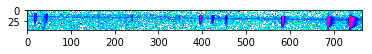

In [535]:
nebulae = nebulae[15:60, :]
plt.imshow(nebulae, cmap='hsv',norm=LogNorm(vmin=.0000001, vmax=2.5));

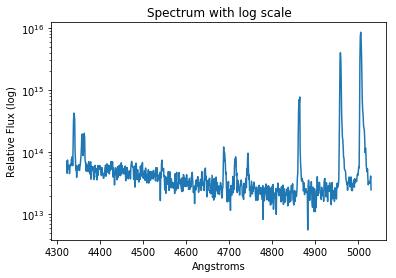

In [536]:
neb_norm = nebulae/data_fitfunc(x) #divide out data fit and destroy everything we worked for
mean = np.median(neb_norm, axis=0)
x = np.linspace(b, b+len(mean)*m, len(mean))
plt.plot(x,mean) 
#.97 is the angstroms per pixel that was previously calculated in lab0
plt.title("Spectrum with log scale")
plt.yscale('log')
plt.xlabel("Angstroms")
#plot on logscale so that all emission lines are very visible
plt.ylabel("Relative Flux (log)");

In [695]:
def peaks(data,epi):
    indices, = np.nonzero(data > epi)
    jumps = (indices[1:] - indices[:-1]) != 1

    lows = list(indices[1:][jumps])
    highs = list(indices[:-1][jumps])

    lows = [indices[1:].min()-2] + lows
    highs = highs + [indices.max()+2]

    indices = [data[lo:hi].argmax() + lo if lo != hi else lo
               for lo, hi in zip(lows, highs)]

    indices = np.array(indices)
    return indices,np.array(lows),np.array(highs)

In [696]:
indices,lows,highs = [],[],[]
epi = 2e14
ind1,low1,high1 = peaks(mean[0:300],epi)

epi = .7e14
ind2,low2,high2 = peaks(mean[300:],epi)

ind2 += 300
low2 += 300
high2 +=300

ind2 = np.delete(ind2,1)
low2 = np.delete(low2,1)
high2 = np.delete(high2,1)

indices = np.append(ind1,ind2)
lows = np.append(low1,low2)
highs = np.append(high1,high2)

[317 318 319 320 344]
[394 395 396 397 398 422 424 425 454 455 581 582 583 584 585 586 684 685
 686 687 688 689 690 691 692 693 694 695 696 735 736 737 738 739 740 741
 742 743 744 745 746 747 748 749 750 751]


In [ ]:
theory = np.array([4341,4363,4686,4711,4740,4861,4959,5007])
m, b = np.polyfit(indices,theory,1)
#obtain a better estimate for the dispersion and for the shifting needed
# m is the better 'ang_per_pix' and b is the better 'shift'

In [716]:
peak_sums = []
for i in range(len(lows)):
    peak_sums.append( [np.trapz(mean[lows[i]:highs[i]])/1e14, indices[i]*m+b] )
peak_sums[3][0] = mean[indices[3]]*m
peak_sums[4][0] = mean[indices[4]]*m
peak_sums

[[9.90767796318976, 4338.669383345869],
 [1.8760005947816756, 4362.700863590811],
 [3.6240621741589476, 4686.201559195801],
 [77549463655827.92, 4713.930190247656],
 [73413273978926.66, 4741.658821299513],
 [22.50111375664991, 4862.740510225951],
 [132.86652736448565, 4957.017855802263],
 [333.88431991699167, 5004.156528590418]]

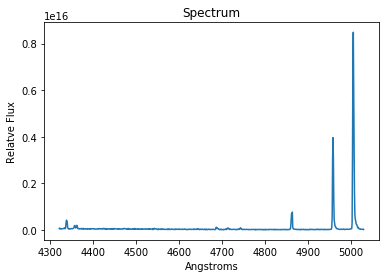

In [544]:
plt.plot(x,mean)
plt.title("Spectrum")
plt.xlabel('Angstroms')
plt.ylabel('Relatve Flux');

In [717]:
np.savetxt('emission_line_strengths.csv', peak_sums, delimiter=',')

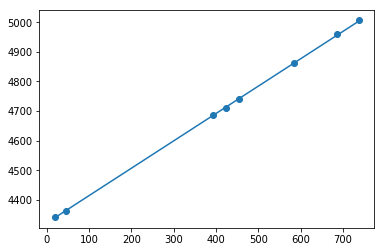

In [547]:
plt.scatter(indices,theory)
y = np.poly1d(np.polyfit(indices,theory,1))
plt.plot(indices,y(indices))